<div align="center">
    <img src='https://media-exp1.licdn.com/dms/image/C561BAQFV4oU27rzxaQ/company-background_10000/0/1562869489836?e=2147483647&v=beta&t=OMHL6Izxqw7r8S5fn9gDQM1hNMKgo3yqMlH1F3Iwm9o' style='height:300px;'>
</div>


<center><h1 style='font-size:35px'>Análisis y visualización de datos - Test de Hipotesis y Comunicacion</h1></center>

---

**Fecha de creación: 20/04/2022**

**Autores**:
* Marilina Trevisan (marilinatrevisan@gmail.com).
* Gustavo Ariel Venchiarutti (gustavo.venchiarutti@gmail.com).
* Ani Salama (anisalama@gmail.com).
* Anahí Sulca (nanisulca@gmail.com).
* Agustín Trulli (agustintrulli@gmail.com).

**Grupo: 6**

El objetivo del presente notebook es aplicar el Test de Hipotesis al conjunto de datos que se propone, analizar el resultado obtenido y realizar las respuestas inherente.

Con este análisis se buscan cubrir todas las consignas correspondientes al trabajo práctico nro. 2 de la materia "Análisis de Visualización de datos" perteneciente a la diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones.


---


In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import scipy.stats

from statsmodels.stats.power import tt_ind_solve_power

seaborn.set_context('talk')

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,...,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,...,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,...,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [4]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                     \
                             count          mean            std   min   
profile_gender                                                          
Hombre                      4944.0  98836.063558  102159.664237   1.0   
Mujer                        908.0  73501.414465   56256.880181   2.0   
Otros                         31.0  95441.354839   88635.674358  40.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          53285.0  80000.0  110000.0  2080000.0  
Mujer           43818.0  65000.0   92000.0   800000.0  
Otros           39500.0  74000.0  117500.0   380000.0

In [5]:
df[df.salary_monthly_NETO > 1000][['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4815.0  101481.624343  102215.304684   1100.0   
Mujer                        863.0   77328.913778   55082.760570   2000.0   
Otros                         28.0  105660.714286   87235.710235  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          55000.0  80000.0  110000.0  2080000.0  
Mujer           47850.0  67200.0   93000.0   800000.0  
Otros           43750.0  78900.0  122750.0   380000.0

In [6]:
alpha = 0.05 


In [7]:
is_man = df.profile_gender == 'Hombre'

groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

## Calculo parámetros poblacionales

Para el desarrollo del práctico, consideramos que la encuesta es la población y vamos a tomar muestras de la misma. 

Calculamos los parametros poblacionales, media, varianza y desviación estándar de ambos grupos para luego obtener el valor poblacional de diferencias de medias µA-µB. 

Luego procedemos a hacer una estimación puntual y un intervalo de confianza para este parámetro utilizando muestras de tamaño n de cada población. 

Usamos la distribución t de student ya que si bien podríamos usar la normal dado que las varianzas poblacionales son conocidas, la t es más abarcativa y funciona casi igual con muchos grados de libertad.

In [8]:

muA = groupA.mean() # promedio
varA = groupA.var() # Desviacion al cuadrado
stdA = groupA.std()
print('Tomando el GRUPO A solo HOMBRES como poblacion de ', len(groupA)) 
print('              El salario Neto Medio Poblacional', muA)
#print('              La Desviacion Standard del Salario Neto Poblacional',stdA)
#print('              La Varianza del Salario Neto oblacional',varA)
#print()
#print()
print()
muB = groupB.mean() # promedio
varB = groupB.var() # Desviacion al cuadrado
stdB = groupB.std() # 
print('Tomando el GRUPO B solo MUJERES y OTROS como poblacion de', len(groupB)) 
print('              El Salario Neto Medio Poblacional', muB)
#print('              La Desviacion Standard del Salario Neto Poblacional',stdB)
#print('              La Varianza del Salario Neto Poblacional',varB)

print()
#El valor que tenemos que analizar es la DIFERENCIA DE LASMEDIUAS
print('El parámero diferencia de las medias es', muA-muB)


Tomando el GRUPO A solo HOMBRES como poblacion de  4815
              El salario Neto Medio Poblacional 101481.62434267912

Tomando el GRUPO B solo MUJERES y OTROS como poblacion de 891
              El Salario Neto Medio Poblacional 78219.25094276095

El parámero diferencia de las medias es 23262.37339991817


# Intervalo de confianza

Calculamos las medias y varianzas muestrales para luego construir el intervalo de confianza con 1-alpha = 0.95.

Consideramos como estadístico la diferencia de medias muestrales mediaA - mediaB.

También se calcula el estadístico t.

In [9]:
nA = 300
muestraA = groupA.sample(nA)
mediaA = muestraA.mean()
vmA = muestraA.var()


print('Tomando como poblacion el GRUPO A solo HOMBRES {} y considerando la muestra de {}. El valor de la media muestral es : {}'.format(len(groupA), nA, mediaA))
print()
print('Tomando como poblacion el GRUPO A solo HOMBRES {} y considerando la muestra de {}. El valor de la varianza muestral es : {}'.format(len(groupA), nA, vmA))
print()

nB = 300
muestraB = groupB.sample(nB)
mediaB = muestraB.mean()
vmB = muestraB.var()


print('Tomando como poblacion el GRUPO B solo MUJERES Y OTROS {} y considerando la muestra de {}. El valor de la Media muestral es : {}'.format(len(groupB), nB, mediaB))
print()
print('Tomando como poblacion el GRUPO B solo MUJERES Y OTROS {} y considerando la muestra de {}. El valor de la Varianza muestral es : {}'.format(len(groupB), nB, vmB))


Tomando como poblacion el GRUPO A solo HOMBRES 4815 y considerando la muestra de 300. El valor de la media muestral es : 106275.532

Tomando como poblacion el GRUPO A solo HOMBRES 4815 y considerando la muestra de 300. El valor de la varianza muestral es : 13759253066.370747

Tomando como poblacion el GRUPO B solo MUJERES Y OTROS 891 y considerando la muestra de 300. El valor de la Media muestral es : 75617.60653333334

Tomando como poblacion el GRUPO B solo MUJERES Y OTROS 891 y considerando la muestra de 300. El valor de la Varianza muestral es : 4515500205.422832


/Users/agustintrulli/miniconda3/envs/diplodatos_ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/agustintrulli/miniconda3/envs/diplodatos_ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='salary_monthly_NETO', ylabel='Density'>

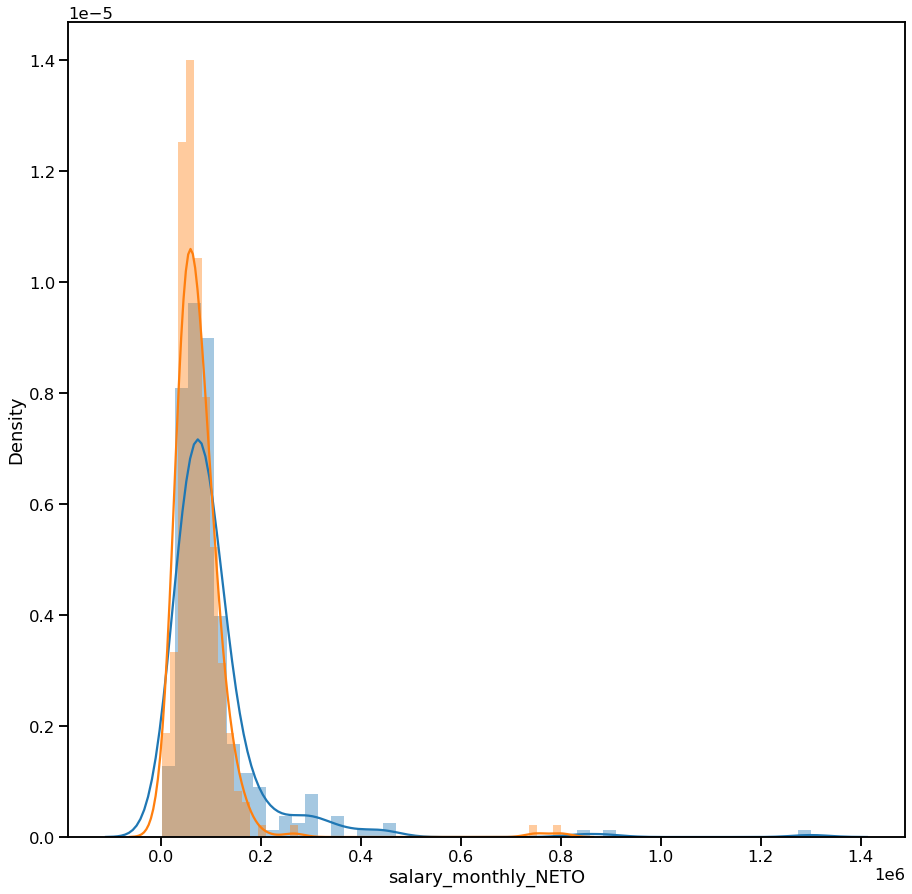

In [10]:
f,ax=plt.subplots(figsize=(15, 15))
seaborn.distplot(muestraA)
seaborn.distplot(muestraB)


In [11]:
# Tengo que buscar los limites entre los cuales se encuetra la diferencias de media poblacional
# considerando como estadístico la diferencia de media muestral

# ESTADISTICO diferencia de las medias muestrales 
est_dif_medias = mediaA - mediaB


# Calculo para distribuciones t de student 
# Tengo que buscar los limites entre los cuales se encuetra la diferencias de media poblacional
# considerando la diferencia de media muestral


t = scipy.stats.t.ppf(q=(1-alpha/2), df=(nA+nB-2), loc=0, scale=1) # valor t de la tabla para probabilidad 0.975 y df = grados de libertad


lim_inf = est_dif_medias - t*np.sqrt(vmA/nA+vmB/nB)
lim_sup = est_dif_medias + t*np.sqrt(vmA/nA+vmB/nB)

print('Valor de la diferencia de medias poblacionales es:', muA-muB)
print('Valor de t obtenido por formula es:', t)
print('El LIMITE INFERIOR calculado para el estadístico diferencia de medias es:', lim_inf)
print('El LIMITE SUPERIOR calculado para el estadístico diferencia de medias es:', lim_sup)
print('Amplitud del intervalo de confianza para el estadístico diferencia de medias:', lim_sup - lim_inf)

Valor de la diferencia de medias poblacionales es: 23262.37339991817
Valor de t obtenido por formula es: 1.9639388980554935
El LIMITE INFERIOR calculado para el estadístico diferencia de medias es: 15329.656737559639
El LIMITE SUPERIOR calculado para el estadístico diferencia de medias es: 45986.1941957737
Amplitud del intervalo de confianza para el estadístico diferencia de medias: 30656.53745821406


**CONCLUSIÓN**

Podemos concluir con 95% de confianza que el parámetro poblacional µA-µB, es decir la diferencia entre el salario neto promedio de los varones y el de otros géneros, se encuentra en el intervalo estimado ARS 11629 - ARS 44329. 

Para construir el intervalo utilizamos muestras de tamaño 300. El tamaño de la muestra es inversamente proporcional a la amplitud del intervalo de confianza, por lo que muestras más grandes arrojaran estimaciones más precisas y viceversa.

La relación entre el intervalod e confianza y el test de hipótesis es que el intervalo de confianza contruido bajo hipótesis nula contiene el rango donde la hipotesis nula se confirma con error tipo I = alpha fuera del intervalo de confianza la hipotesis nula se rechaza. Dicho de otra forma si el estadistico observado se encuentra dentro del intervalo de confianza construido bajo hipotesis nula, quiere decir que no se rechaza la H0 con alpha de significancia.


## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos compenentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

Para el test de hpótesis consideramos muestras de tamaño 400 ya que al estimar el tamaño de la muestra necesario para una potencia del 0.9 se necesitan 399 observaciones.

Es un test bilateral y asumimos que el estadístico diferencia de medias tiene distribución t de student con nA+nB-2 grados de libertad ya que las varianzas poblacionales se consideran desconocidas y diferentes (Test de Welch)

#### Formulación de Hipotesis

**Hipótesis Nula** 
La diferencia de las medias poblacionales entre el grupo A varones y el grupo B otros generos no es estadísticamente significativa, es decir, las medias poblacionales de ambos grupos son iguales o su diferencia es nula.

$H_0: µA=µB$  ó bien $µA-µB=0$

**Hipotesis Alternativa**
La diferencia de las medias poblacionales entre el grupo A varones y el grupo B otros generos es estadísticamente significativa.

$H_1: µA≠µB$ ó bien $µA-µB≠0$

#### Nivel de signiuficancia del test

Necesitamos asegurar que la descicion correcta sea del 95%

In [12]:
# Nivel de significancia= la probabilidad de rechazar la hipotesios nula cuando esta es verdadera
alpha = 0.05

#### Ejecucion tomando las muestras
Se toman las muestras y se calcula el valor observado del estadístico diferencia de medias muestrales. Se calculan los valores de la distribución t teóricos para el valor alpha = 0.05.

REGLA DE DECISIÓN: Como la prueba es bilateral tenemos dos valores de t críticos (-$t_c$ y $t_c$). Si el t observado ($t_p$) se encuentra entre estos valores se acepta la hipótesis nula y si queda por fuera de este rango se rechaza. 

SE ACEPTA LA HIPÓTESIS NULA SI:

 -$t_c$ < $t_p$ < $t_c$

SE RECHAZA LA HIPÓTESIS NULA SI:

$t_p$ < -$t_c$  ó  $t_p$ > $t_c$

In [13]:

# Tamaño de las muestras para ambos grupos es de 30 elementos en total
nA = 800
nB = 400
muestraA = groupA.sample(nA, replace=False)
muestraB = groupB.sample(nB, replace=False)

In [14]:
# Calculo el tc utilizando la formula y los grados de libertad que fijan las muestras
#LA PRUEBA ES BILATERAL POR LO QUE TENEMOS DOS VALORES DE t.

tc = scipy.stats.t.ppf(q=(1-alpha/2), df=(nA+nB-2), loc=0, scale=1) # valor t de la tabla para probabilidad 0.975 y df = grados de libertad
print(tc*-1)
print(tc)



-1.961946145659345
1.961946145659345


In [15]:
# Realizo los calculos de las medias mecesarias para calcular el tp

mediaA = muestraA.mean()
mediaB = muestraB.mean()

diferencia_medias=mediaA-mediaB

vmA = muestraA.var()
vmB = muestraB.var()

coefA=(vmA/nA)
coefB=(vmB/nB)
print(diferencia_medias)

17186.181225000008


In [16]:
# Calculo el estadistico de prueba

tp= diferencia_medias/(np.sqrt(coefA+coefB))

tp

3.569235297524174

#### DECISION

Se decide rechazar la hipótesis nula ya que $t_p$ > $t_c$

Por tanto, podemos afirmar con una significancia del 5% (α=0.05) que los salarios netos promedio de los hombres es distinto al de los otros géneros. Como se observa la diferencia es positiva, es decir los varones ganan más que las mujeres y otros.

### 2.2 P-valor

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.

In [17]:
#estadistico diferencia de medias muestrales
# se distribuye t con n1+n2-2 grados de libertad media mu1-mu2 , var sigma1/n1+sigma2/n2

#con scipy

scipy.stats.ttest_ind(muestraA, muestraB, equal_var=False) #statistic es el valor t donde t = dif mediamuestral - dif mu / sqrt(var1 /n1 + var2/n2)
#cuando se asume que las varianzas no son iguales test Welsch
#la fcn no lleva como parametro alpha porq funciona para cualquier alpha... se compara con el p


Ttest_indResult(statistic=3.569235297524174, pvalue=0.00037443669971521867)

2. Interprete el resultado.


De este calculo obtenemos nuevamente el valor $t_p$ que nos llevó a rechazar la hipótesis nula. 

El p valor es la probabilidad relacionada con el valor observado de t ($t_p$). Al ser este valor menor que alpha (0.05) llegamos a la misma conclusión de rechazar la hipótesis nula.

RECHAZO la hipotesis µA=µB con significancia 5% dado que p valor < alpha

3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?

El tamaño de las muestras si afecta al test, de acuerdo incrementamos el tamaño de las muestras reducimos el error de tipo II.

Sin embargo, el problema relacionado con la desigualdad en los tamaños de muestras de los distintos grupos se elimina usando el test de Welch. El test de Welch arroja el mismo p valor cuando las varianzas y/o los tamaños muestrales no son iguales.

Fuente: http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [18]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)

In [19]:
#la potencia es 1- beta la probabilidad de rechazar la hip nula cuando esta es falsa (1 -error tipo II)
power = [0.8, 0.9, 0.95]
for p in power:
  tam = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=p, ratio=ratio)
  print("Tamaño de muestra necesario para potencia",p,":", tam)
  


Tamaño de muestra necesario para potencia 0.8 : 298.3073379956589
Tamaño de muestra necesario para potencia 0.9 : 398.7961001403289
Tamaño de muestra necesario para potencia 0.95 : 492.8117730249174


## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.


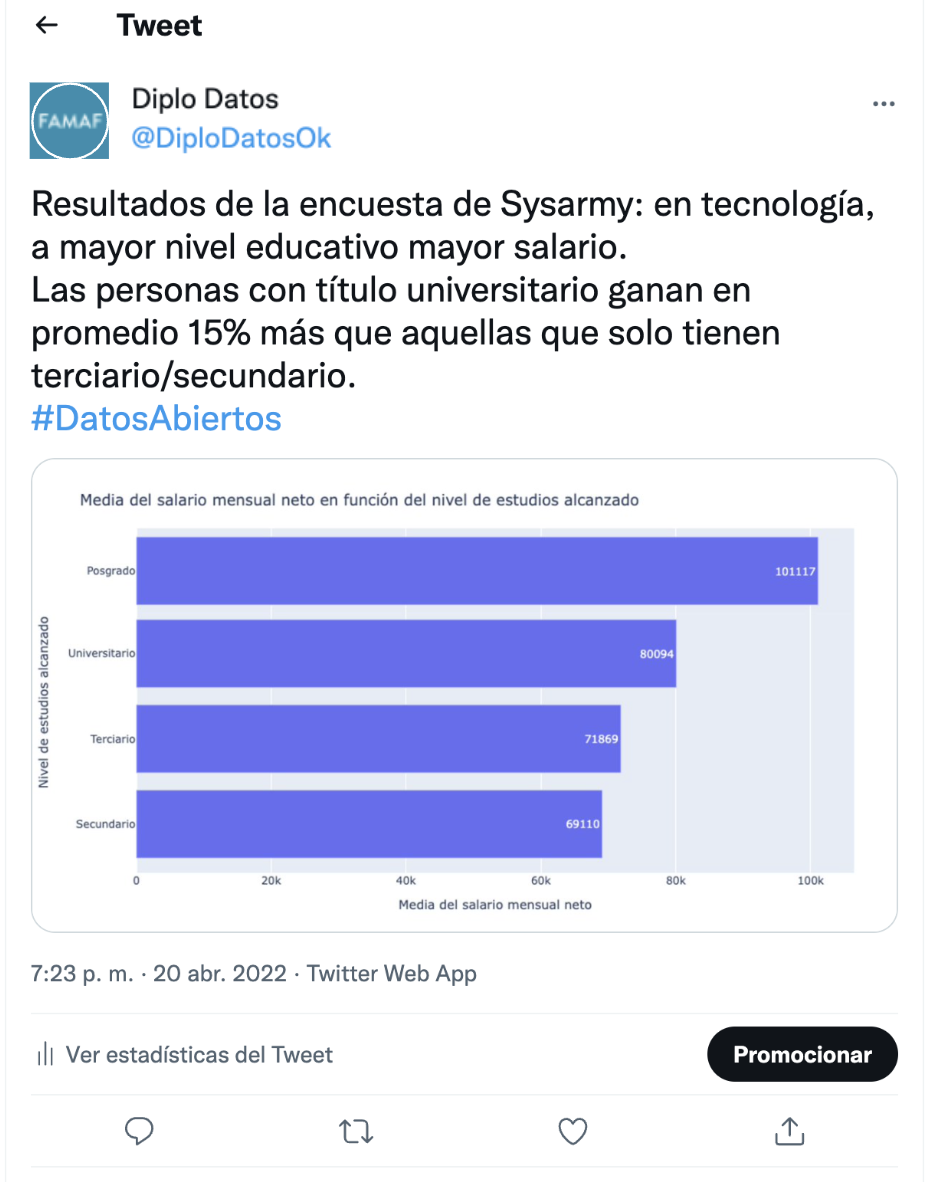

Los datos los obtuvimos de la encuesta Sysarmy 2020. Para filtrar outliers  utilizamos dos desviaciones estándar como filtros o rango intercuartílico. Además Primario (2), Postdoctorado (4) y Doctorado (30) fueron eliminados debido a la escasa cantidad de registros. De esta forma quedaron 5564 registros distribuidos en los cuatro niveles de estudios analizados.